--- 

# <center> Project ML for Time Series 
## <center> Regression Problem


<center> Realized By: 

##### <center> Eya Ghamgui $~~$ eya.ghamgui@telecom-paris.fr
##### <center> Siwar Mhadhbi $~~$ siwar.mhadhbi@telecom-paris.fr

---

## Importations 

In [ ]:
# Import utility packages
import time
import calendar
import datetime
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set visualization formats
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

# Import custom functions
from models import RF_regression, GB_regression, NN_regression
from functions import REFS, UDFS, laplacian_score

import warnings
warnings.filterwarnings("ignore")

## Data Retrieval

In [ ]:
# Load data
in_dd = pd.read_csv('stock.csv') 
in_dd['date'] = pd.to_datetime(in_dd['date'])

# Reindex the data
in_dd=in_dd.reset_index()
in_dd=in_dd.set_index(['date']).sort_index()

Features:
- **Id:** a unique ID for every observation
- **date:** date of the trading session
- **company_code:** company code
- **company:** company name
- **yesterday_price:** close price of yesterday's trading session
- **open:** open price of current trading session
- **last:** last price of current trading session
- **close:** close price of current trading session
- **low:** lowest price of current trading session
- **high:** highest price of current trading session
- **qty_traded:** total quantity traded (in number of shares) in current trading session
- **num_trades:** total number of trades in current trading session
- **value:** total value traded in current trading session

Target:
- **next_day_ret:** next day's return (response to predict)

## Checking Missing Values

In [ ]:
# Computing the number of missing values 
MV = pd.DataFrame(in_dd.isna().sum(), columns=['Number of missing values'])
MV.head(22).style.set_properties(**{'background-color': '#c6ccd8'})

,Number of missing values
index,0
Id,0
company_code,0
company,0
yesterday_price,0
open,0
last,0
close,0
low,0
high,0


In [ ]:
# Changing nan values with the median 
median=in_dd.groupby('company')['value'].median().to_frame()
median.rename(columns={'value':'median'},inplace=True)
in_dd=in_dd.reset_index()
in_dd=in_dd.merge(median,on=['company'])
in_dd=in_dd.set_index(['date']).sort_index()
in_dd.loc[in_dd['value'].isnull(),'value']=in_dd.loc[in_dd['value'].isnull(),'median']
in_dd.drop(columns=['median'],inplace=True)

# Select one company to work on 
data = in_dd.loc[in_dd.company == 'UBCI']

# Drop unnecessary columns
data = data.drop(columns=['index', 'Id', 'company_code', 'company'])

# Final data 
data.head()

,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,next_day_ret
date,,,,,,,,,,
2018-01-02,24.81,0.0,0.0,24.81,0.0,0.0,0,0,4310.715,-86.889657
2018-01-03,24.81,0.0,0.0,24.81,0.0,0.0,0,0,4310.715,13.168893
2018-01-04,24.81,0.0,0.0,24.81,0.0,0.0,0,0,4310.715,-25.764411
2018-01-05,24.81,0.0,0.0,24.81,0.0,0.0,0,0,4310.715,-71.539961
2018-01-08,24.81,0.0,0.0,24.81,0.0,0.0,0,0,4310.715,65.088711


## Data Visualization 

### 1. Next day return target

In [ ]:
# Visualize the signal
fig = make_subplots(rows=1, cols=1, subplot_titles=['Next day Return'])
fig.add_trace(go.Scatter(x=data.index, y=data['next_day_ret'], fill='tozeroy', fillcolor='#c6ccd8'))

### 2. Removing Outliers


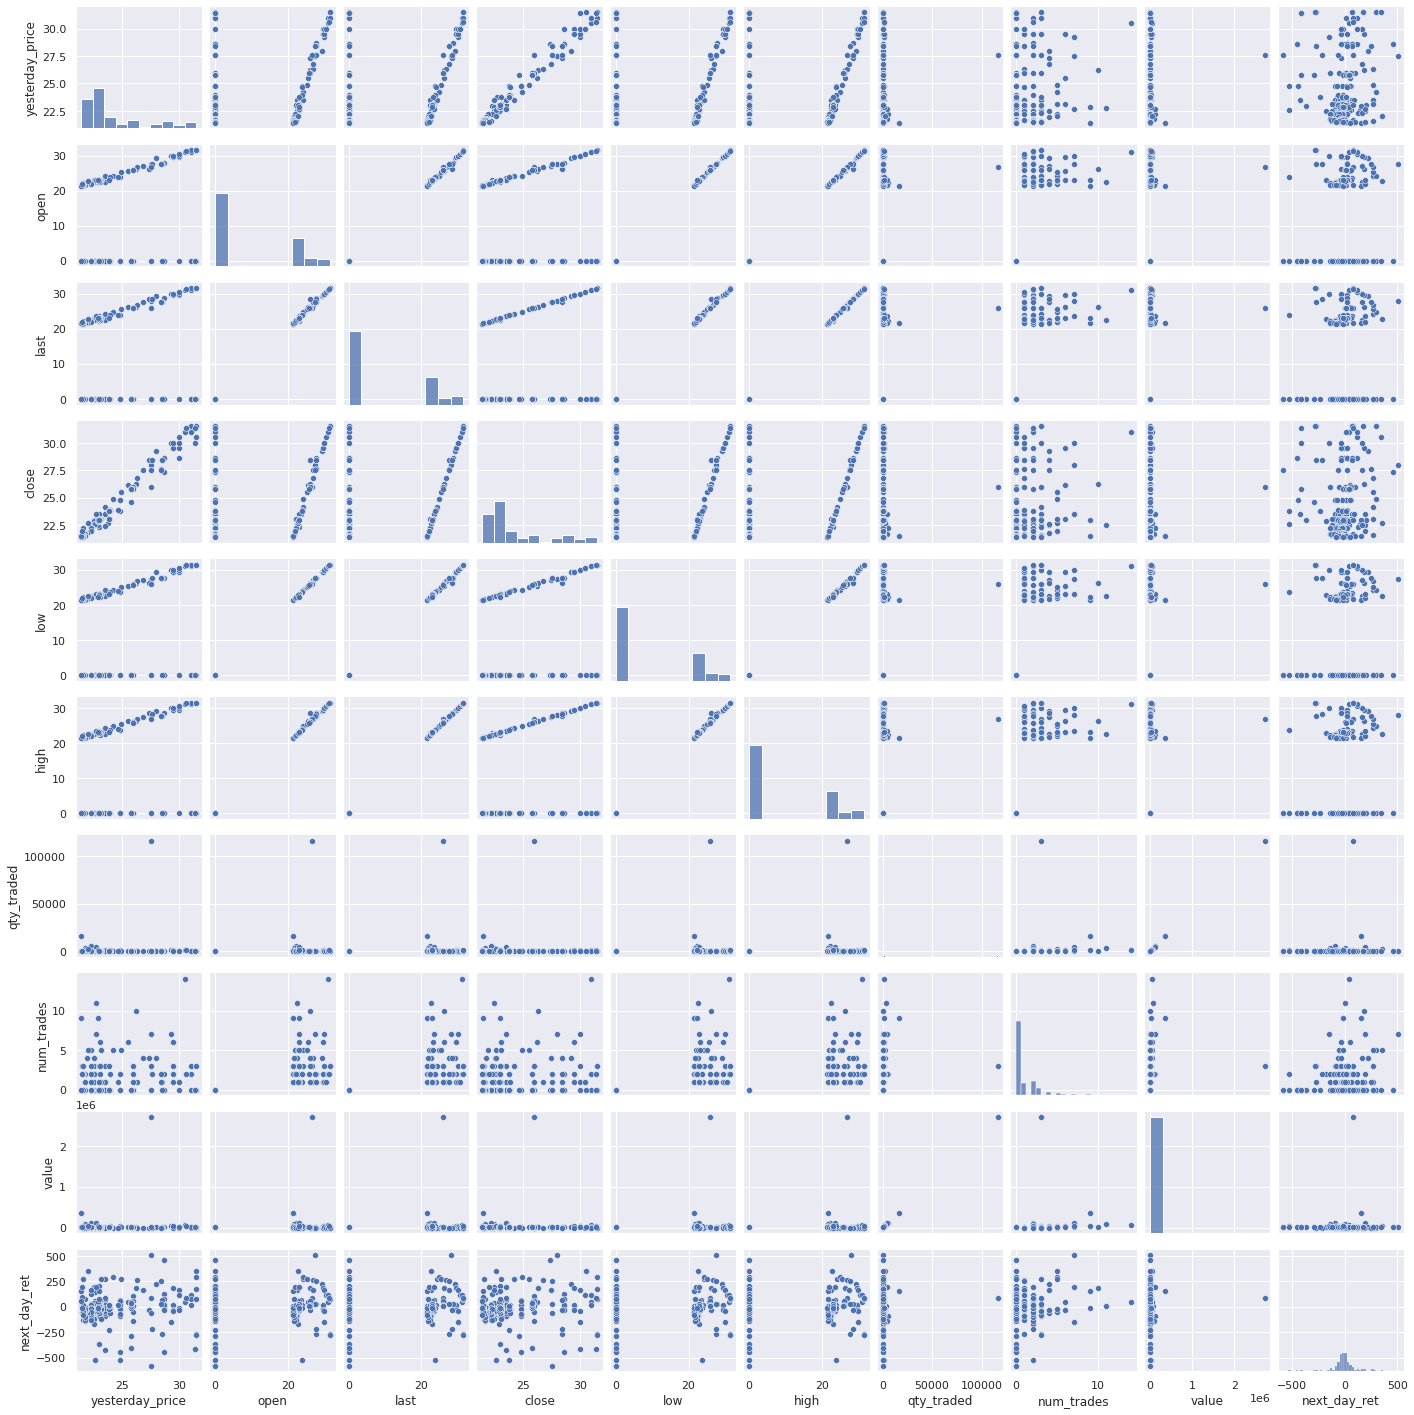

In [ ]:
# Pair plot before removing outliers 
sns.pairplot(data,height=2);

In [ ]:
# Outlier detection of isolated samples
original_data = data.copy()
fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram of value feature','Histogram of qty_traded'])
fig.add_trace(go.Histogram(x=data['value']),row=1,col=1)
fig.add_trace(go.Histogram(x=data['qty_traded']),row=1,col=2)
fig.add_vline(x=0.2e6, line_width=2, line_dash="dash", line_color="red",row=1,col=1)
fig.add_vline(x=13e3, line_width=2, line_dash="dash", line_color="red",row=1,col=2)
fig.update_layout(height=600, width=1800, bargap=0.1, showlegend=False)
fig.show()

In [ ]:
# Apply Median filtering for the detected outlier

w = 10
idx_outliers = data[data['value']> 0.2e6].index.tolist()
for idx in idx_outliers:
  idx_outlier = data['value'].index.tolist().index(idx)
  idx_window = data['value'].index[idx_outlier-w:idx_outlier+w]
  median_value = data['value'][idx_window].median()
  data['value'][idx_outlier] = median_value

idx_outliers = data[data['qty_traded']>13e3].index.tolist()
for idx in idx_outliers:
  idx_outlier = data['qty_traded'].index.tolist().index(idx)
  idx_window = data['qty_traded'].index[idx_outlier-w:idx_outlier+w]
  median_value = data['qty_traded'][idx_window].median()
  data['qty_traded'][idx_outlier] = median_value

# Visualize result
fig = make_subplots(rows=2, cols=2, subplot_titles=['value - original','value - after median filter','qty_traded - original','qty_traded - after median filter'])
fig.add_trace(go.Scatter(x=data.index, y=original_data['value'] , mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['value'], mode='lines'), row=1, col=2)
fig.add_trace(go.Scatter(x=data.index, y=original_data['qty_traded'] , mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['qty_traded'], mode='lines'), row=2, col=2)

fig.update_layout(height=800, width=1300,showlegend=False)
fig.show()

### 3. Correlation between features & target

In [ ]:
corr = data.corr().round(2)

fig = make_subplots(rows=1, cols=1, subplot_titles =['Correlation between features'])
fig.add_trace(go.Heatmap(x=corr.columns, y=corr.columns, z=corr,colorscale='RdBu', text= corr.to_numpy().astype('str'), texttemplate="%{text}"),row=1,col=1)
fig.update_layout(height=800, width=800)

### 4. Features in function of time

In [ ]:
fig = make_subplots(rows=6, cols=2, subplot_titles=['yesterday_price','value', 'open','num_trades', 'last','qty_traded','close','', 'low','','high'])

fig.add_trace(go.Scatter(x=data.index, y=data['yesterday_price'], mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['open'], mode='lines' ), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['last'], mode='lines'), row=3, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines'), row=4, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['low'], mode='lines'), row=5, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['high'], mode='lines'), row=6, col=1)

fig.add_trace(go.Scatter(x=data.index, y=data['value'], mode='lines'), row=1, col=2)
fig.add_trace(go.Scatter(x=data.index, y=data['num_trades'], mode='lines'), row=2, col=2)
fig.add_trace(go.Scatter(x=data.index, y=data['qty_traded'], mode='lines'), row=3, col=2)

fig.update_layout(height=1000, width=1800,showlegend=False)

## Add New Features 

In [ ]:
# Calculate daily return
data['currReturn'] = data['close'].pct_change().replace({np.inf : np.NaN , -np.inf : np.NaN}).fillna(0)

# qty traded / num_trades
data['qty_divided'] = (data['qty_traded']/data['num_trades']).replace({np.inf : np.NaN , -np.inf : np.NaN}).fillna(0)

# currReturn * close
data['price_returns'] = data['close']*data['currReturn']

# Divide the open by the daily returns
data['open_divided']=(data['open']/data['currReturn']).replace({np.inf : np.NaN , -np.inf : np.NaN}).fillna(0)

# Adding some polynomial features : currReturn²
data['puis_returns'] = data['currReturn']**2

In [ ]:
fig = make_subplots(rows=3, cols=2, subplot_titles=['currReturn','qty_divided','price_returns','open_divided','puis_returns'])

fig.add_trace(go.Scatter(x=data.index, y=data['currReturn'], mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['qty_divided'], mode='lines'), row=1, col=2)
fig.add_trace(go.Scatter(x=data.index, y=data['price_returns'], mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['open_divided'], mode='lines'), row=2 ,col=2)
fig.add_trace(go.Scatter(x=data.index, y=data['puis_returns'], mode='lines'), row=3, col=1)

fig.update_layout(height=600, width=1800,showlegend=False)

In [ ]:
# Correlation between all features (old features + new features)
corr = data.corr().round(2)

fig = make_subplots(rows=1, cols=1, subplot_titles =['Correlation between features'])
fig.add_trace(go.Heatmap(x=corr.columns, y=corr.columns, z=corr,colorscale='RdBu', text= corr.to_numpy().astype('str'), texttemplate="%{text}"),row=1,col=1)
fig.update_layout(height=800, width=800)

## Train Test Split 

In [ ]:
# Train test split 
X = data.drop(columns=['next_day_ret']).to_numpy()
y = data['next_day_ret'].to_numpy()

# 14 features 
features = ['yesterday_price', 'open', 'last', 'close', 'low', 'high', 'qty_traded','num_trades', 'value',
            'currReturn','qty_divided','price_returns','open_divided','puis_returns']

size1 = int(np.round(data.shape[0] * 0.8))
X_train = X[:size1]
y_train = y[:size1]

X_test = X[size1:]
y_test = y[size1:]

print('The size of train data :', X_train.shape[0], 'samples which is', round(X_train.shape[0]/data.shape[0]*100),'% of data' )
print('The size of test data :', X_test.shape[0], 'samples which is', round(X_test.shape[0]/data.shape[0]*100) ,'% of data' )

data2 = data[size1-1:size1+1]
fig = make_subplots(rows=1, cols=1,subplot_titles =['Next day return (train + test)'])
fig.add_trace(go.Scatter(x=data.index[:size1], y=data['next_day_ret'][:size1], marker={'color':'#496595'},fill='tozeroy', fillcolor='#c6ccd8',mode='lines'),row=1, col=1)
fig.add_trace(go.Scatter(x=data2.index, y=data2['next_day_ret'], marker={'color':'#496595'},fill='tozeroy', fillcolor='#c6ccd8', mode='lines'),row=1, col=1)
fig.add_trace(go.Scatter(x=data.index[size1:], y=data['next_day_ret'][size1:], marker={'color':'#FC5A50'}, fill='tozeroy', fillcolor='#c6ccd8',mode='lines'),row=1, col=1)
fig.update_layout(showlegend=False)
fig.show()

The size of train data : 199 samples which is 80 % of data
The size of test data : 50 samples which is 20 % of data


## Scaling Numerical Features 

In [ ]:
# Scale the data
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

## Modeling

### 1. Random Forest Regressor 

In [ ]:
mae, rmse, mape = RF_regression(X_train, y_train, X_test, y_test, data.index, size1)

Best Validation Score: 103.62660640811589
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}


Mean Absolute Error on test data: 74.661
Root Mean Squared Error on test data: 101.685
Mean Absolute Percentage Error on test data: 5.312


### 2. Gradient Boosting Regressor

In [ ]:
GB_regression(X_train, y_train, X_test, y_test, data.index, size1)

Best Validation Score: 98.35919350847688
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 10}


Mean Absolute Error on test data: 73.782
Root Mean Squared Error on test data: 98.985
Mean Absolute Percentage Error on test data: 6.125


### 3. Neural Network 

In [ ]:
NN_regression(X_train, y_train, X_test, y_test, data.index, size1)

Epoch 1/120
16/16 [==============================] - 3s 47ms/step - loss: 16591.3340 - root_mean_squared_error: 128.8074 - val_loss: 45019.2891 - val_root_mean_squared_error: 212.1775
Epoch 2/120
16/16 [==============================] - 0s 15ms/step - loss: 16174.3564 - root_mean_squared_error: 127.1784 - val_loss: 45349.2383 - val_root_mean_squared_error: 212.9536
Epoch 3/120
16/16 [==============================] - 0s 13ms/step - loss: 16131.6035 - root_mean_squared_error: 127.0102 - val_loss: 45054.9141 - val_root_mean_squared_error: 212.2614
Epoch 4/120
16/16 [==============================] - 0s 12ms/step - loss: 15905.1836 - root_mean_squared_error: 126.1158 - val_loss: 46959.4258 - val_root_mean_squared_error: 216.7012
Epoch 5/120
16/16 [==============================] - 0s 13ms/step - loss: 15541.9307 - root_mean_squared_error: 124.6673 - val_loss: 45330.4609 - val_root_mean_squared_error: 212.9095
Epoch 6/120
16/16 [==============================] - 0s 14ms/step - loss: 15910.

Mean Absolute Error on test data: 82.606
Root Mean Squared Error on test data: 111.791
Mean Absolute Percentage Error on test data: 4.411


## Feature Extraction 

### 1. Sparse Learning Based

#### 1.1 REFS: 

Solve the optimization problem: 

$$ \underset{W}{min} 
\left\lVert XW - Y \right\rVert_{2,1}
 + \alpha \left\lVert W \right\rVert_{2,1} $$ 

In [ ]:
# Tunining the parameter alpha 

max_iter= 1000
eps= 1e-3
alpha_list = np.arange(0.1,1,0.05) 
mae_list = []
rmse_list = []

for alpha in tqdm(alpha_list) : 
   W_REFS = REFS(X, y.reshape(-1,1), alpha, max_iter, eps)
   th = np.max(W_REFS)/2
   X_REFS = X[:,np.where(W_REFS>th)[0]]
   X_train_REFS = X_REFS[:size1]
   X_test_REFS = X_REFS[size1:]
   mae, rmse, mape = RF_regression(X_train_REFS, y_train, X_test_REFS, y_test, data.index, size1, plot = False)
   mae_list.append(mae)
   rmse_list.append(rmse)

dd_mae = pd.DataFrame(mae_list , index = alpha_list , columns = ['MAE'])
dd_rmse = pd.DataFrame(rmse_list , index = alpha_list , columns = ['RMSE'])

fig = make_subplots(rows=1, cols=2,subplot_titles =['MAE in function of alpha','RMSE in function of alpha'])
fig.add_trace(go.Scatter(x=dd_mae.index,y=dd_mae.MAE, marker={'color':'#496595'},mode='lines'),row=1, col=1)

fig.add_trace(go.Scatter(x=dd_rmse.index,y=dd_rmse.RMSE, marker={'color':'#496595'}, mode='lines'),row=1, col=2)
fig.add_vline(x=alpha_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=1)
fig.add_vline(x=alpha_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=2)
fig.update_xaxes(title_text="alpha", row=1, col=1)
fig.update_xaxes(title_text="alpha", row=1, col=2)

fig.update_layout(showlegend=False)
fig.show()

  0%|          | 0/18 [00:00<?, ?it/s]

Time to finish:  0.02366781234741211 seconds



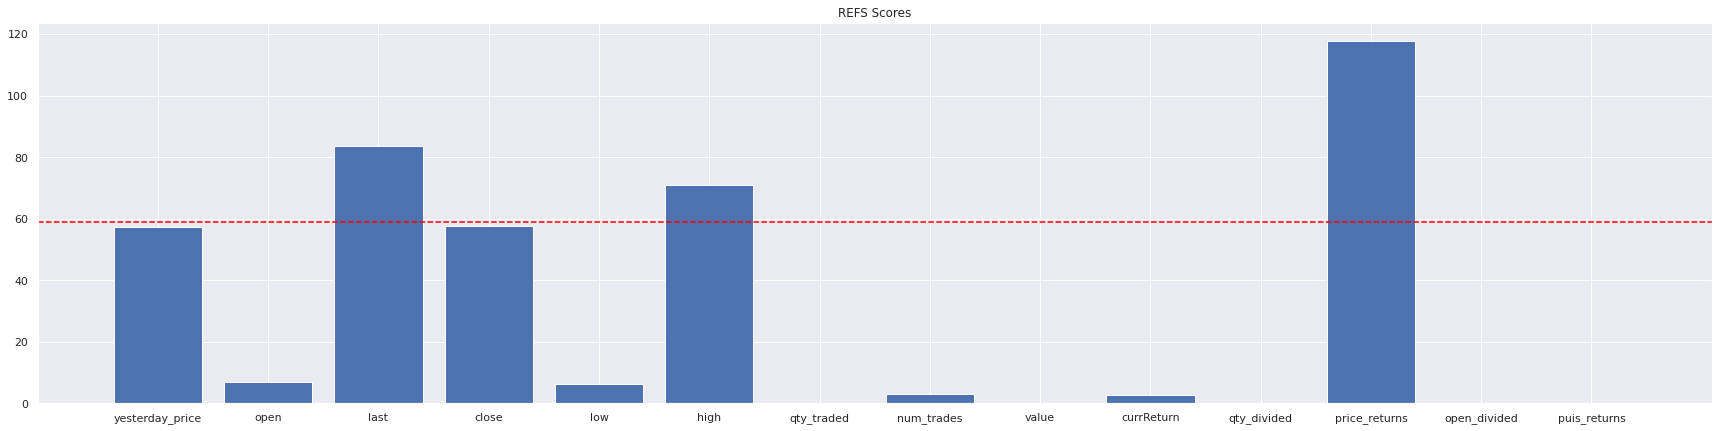

In [ ]:
# Select features based on the previous selected parameter 
alpha = alpha_list[np.argmin(rmse_list)]

start_time=time.time()
W_REFS = REFS(X, y.reshape(-1,1), alpha, max_iter, eps)
end_time=time.time()

W_REFS = np.abs(W_REFS).reshape(-1)
print('Time to finish: ', end_time - start_time,'seconds\n')

th = np.max(W_REFS)/2

# Display the weights of features 
plt.figure(figsize=(30,7))
plt.title('REFS Scores')
plt.bar(features, W_REFS)
plt.axhline(y=th, color= 'red',linestyle='--')
plt.show()

# Train test split 
X_REFS = X[:,np.where(W_REFS>th)[0]]
X_train_REFS = X_REFS[:size1]
X_test_REFS = X_REFS[size1:]

In [ ]:
print('- Random Forest:')
mae, rmse, mape = RF_regression(X_train_REFS, y_train, X_test_REFS, y_test, data.index, size1)

- Random Forest:
Best Validation Score: 103.65187069787994
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}


Mean Absolute Error on test data: 69.676
Root Mean Squared Error on test data: 108.248
Mean Absolute Percentage Error on test data: 3.993


In [ ]:
print('- Gradient Boosting:')
GB_regression(X_train_REFS, y_train, X_test_REFS, y_test, data.index, size1)

- Gradient Boosting:
Best Validation Score: 102.10821555399644
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 10}


Mean Absolute Error on test data: 69.336
Root Mean Squared Error on test data: 111.701
Mean Absolute Percentage Error on test data: 4.237


In [ ]:
print('- Neural Network:')
NN_regression(X_train_REFS, y_train, X_test_REFS, y_test, data.index, size1)

- Neural Network:
Epoch 1/120
16/16 [==============================] - 3s 44ms/step - loss: 16506.8418 - root_mean_squared_error: 128.4790 - val_loss: 44819.0938 - val_root_mean_squared_error: 211.7052
Epoch 2/120
16/16 [==============================] - 0s 7ms/step - loss: 16712.4121 - root_mean_squared_error: 129.2765 - val_loss: 45386.5078 - val_root_mean_squared_error: 213.0411
Epoch 3/120
16/16 [==============================] - 0s 8ms/step - loss: 16598.0195 - root_mean_squared_error: 128.8333 - val_loss: 44731.9805 - val_root_mean_squared_error: 211.4994
Epoch 4/120
16/16 [==============================] - 0s 7ms/step - loss: 16293.9414 - root_mean_squared_error: 127.6477 - val_loss: 44948.0273 - val_root_mean_squared_error: 212.0095
Epoch 5/120
16/16 [==============================] - 0s 7ms/step - loss: 16337.0078 - root_mean_squared_error: 127.8163 - val_loss: 45076.7148 - val_root_mean_squared_error: 212.3128
Epoch 6/120
16/16 [==============================] - 0s 7ms/step -

Mean Absolute Error on test data: 62.066
Root Mean Squared Error on test data: 97.09
Mean Absolute Percentage Error on test data: 3.951


#### 1.2 UDFS 


Solve the optimization problem: 

$$ \underset{W^TW = I_d}{min}~~ \sum_{i=1}^n \{ Tr(G^T_{(i)} H_{k+1}G_{(i)} - DS_i)\} + \gamma || W ||_{2,1} $$  


In [ ]:
# Tunining the parameter gamma 
max_iter= 1000
eps= 1e-3
c = 2
k = 2

gamma_list = np.arange(0.05,1,0.05) 
mae_list = []
rmse_list = []

for gamma in tqdm(gamma_list): 
   W_UDFS = np.abs(np.max(UDFS(X, gamma, c, k, max_iter, eps), axis=1))
   th = np.max(W_UDFS)/2
   X_UDFS = X[:,np.where(W_UDFS>th)[0]]
   X_train_UDFS = X_UDFS[:size1]
   X_test_UDFS = X_UDFS[size1:]
   mae, rmse, mape = RF_regression(X_train_UDFS, y_train, X_test_UDFS, y_test, data.index, size1, plot = False)
   mae_list.append(mae)
   rmse_list.append(rmse)

dd_mae = pd.DataFrame(mae_list , index = gamma_list , columns = ['MAE'])
dd_rmse = pd.DataFrame(rmse_list , index = gamma_list , columns = ['RMSE'])

fig = make_subplots(rows=1, cols=2,subplot_titles =['MAE in function of gamma','RMSE in function of gamma'])
fig.add_trace(go.Scatter(x=dd_mae.index,y=dd_mae.MAE, marker={'color':'#496595'},mode='lines'),row=1, col=1)
fig.add_trace(go.Scatter(x=dd_rmse.index,y=dd_rmse.RMSE, marker={'color':'#496595'}, mode='lines'),row=1, col=2)
fig.add_vline(x=gamma_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=1)
fig.add_vline(x=gamma_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=2)
fig.update_xaxes(title_text="gamma", row=1, col=1)
fig.update_xaxes(title_text="gamma", row=1, col=2)

fig.update_layout(showlegend=False)
fig.show()

  0%|          | 0/19 [00:00<?, ?it/s]

time to finish:  0.2914607524871826 seconds


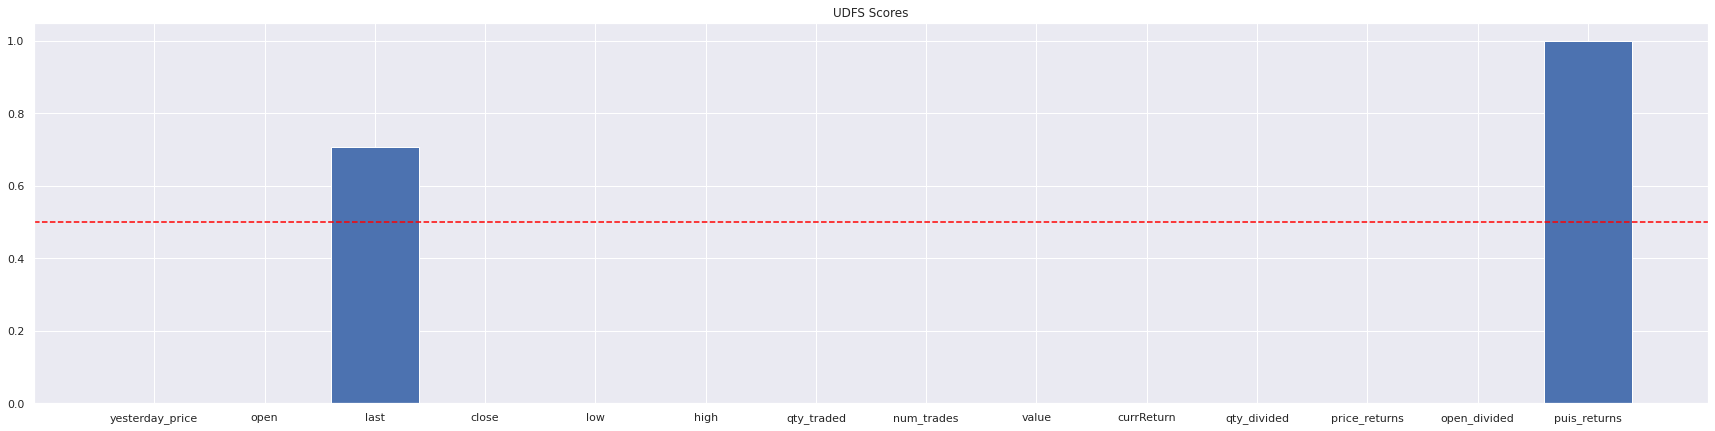

In [ ]:
# Select features based on the previous selected parameter 
gamma = gamma_list[np.argmin(rmse_list)]

start_time=time.time()
W_UDFS = np.abs(np.max(UDFS(X, gamma, c, k, max_iter, eps), axis=1))
end_time=time.time()
print('time to finish: ', end_time - start_time,'seconds')

th = np.max(W_UDFS)/2

# Display the weights of features
plt.figure(figsize=(30,7))
plt.title('UDFS Scores')
plt.bar(features, W_UDFS)
plt.axhline(y=th, color= 'red',linestyle='--')
plt.show()

# Train test split 
X_UDFS = X[:,np.where(W_UDFS>th)[0]]
X_train_UDFS = X_UDFS[:size1]
X_test_UDFS = X_UDFS[size1:]

In [ ]:
print('- Random Forest:')
mae, rmse, mape = RF_regression(X_train_UDFS, y_train, X_test_UDFS, y_test, data.index, size1)

- Random Forest:
Best Validation Score: 103.15596588400236
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}


Mean Absolute Error on test data: 60.343
Root Mean Squared Error on test data: 94.967
Mean Absolute Percentage Error on test data: 3.398


In [ ]:
print('- Gradient Boosting:')
GB_regression(X_train_UDFS, y_train, X_test_UDFS, y_test, data.index, size1)

- Gradient Boosting:
Best Validation Score: 100.06883219605443
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 10}


Mean Absolute Error on test data: 59.409
Root Mean Squared Error on test data: 93.601
Mean Absolute Percentage Error on test data: 3.223


In [ ]:
print('- Neural Network:')
NN_regression(X_train_UDFS, y_train, X_test_UDFS, y_test, data.index, size1)

- Neural Network:
Epoch 1/120
16/16 [==============================] - 3s 38ms/step - loss: 16633.4648 - root_mean_squared_error: 128.9708 - val_loss: 44693.5195 - val_root_mean_squared_error: 211.4084
Epoch 2/120
16/16 [==============================] - 0s 7ms/step - loss: 16554.9277 - root_mean_squared_error: 128.6660 - val_loss: 44764.0156 - val_root_mean_squared_error: 211.5751
Epoch 3/120
16/16 [==============================] - 0s 6ms/step - loss: 16302.9053 - root_mean_squared_error: 127.6828 - val_loss: 44885.0117 - val_root_mean_squared_error: 211.8608
Epoch 4/120
16/16 [==============================] - 0s 6ms/step - loss: 16019.2344 - root_mean_squared_error: 126.5671 - val_loss: 45692.2617 - val_root_mean_squared_error: 213.7575
Epoch 5/120
16/16 [==============================] - 0s 7ms/step - loss: 16199.2158 - root_mean_squared_error: 127.2761 - val_loss: 45261.3555 - val_root_mean_squared_error: 212.7472
Epoch 6/120
16/16 [==============================] - 0s 6ms/step -

Mean Absolute Error on test data: 54.892
Root Mean Squared Error on test data: 95.486
Mean Absolute Percentage Error on test data: 2.341


### 2. Similarity Based : Laplacian Score

Solve the optimization problem: 

$$\underset{S}{max} \sum_{f \in S} \hat{f}^T \hat{S} \hat{f} $$ 

In [ ]:
# Tunining the parameter var 
k = 50
var_list = np.arange(10,100,10) 
mae_list = []
rmse_list = []

for var in tqdm(var_list): 
   W_LS = laplacian_score(X, var=var, k =k)
   th = np.max(W_LS)/2
   X_LS = X[:,np.where(W_LS> th)[0]] 
   X_train_LS = X_LS[:size1]
   X_test_LS = X_LS[size1:]
   mae, rmse, mape = RF_regression(X_train_LS, y_train, X_test_LS, y_test, data.index, size1, plot = False)
   mae_list.append(mae)
   rmse_list.append(rmse)

dd_mae = pd.DataFrame(mae_list , index = var_list , columns = ['MAE'])
dd_rmse = pd.DataFrame(rmse_list , index = var_list , columns = ['RMSE'])

fig = make_subplots(rows=1, cols=2,subplot_titles =['MAE in function of var','RMSE in function of var'])
fig.add_trace(go.Scatter(x=dd_mae.index,y=dd_mae.MAE, marker={'color':'#496595'},mode='lines'),row=1, col=1)
fig.add_trace(go.Scatter(x=dd_rmse.index,y=dd_rmse.RMSE, marker={'color':'#496595'}, mode='lines'),row=1, col=2)
fig.add_vline(x=var_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=1)
fig.add_vline(x=var_list[np.argmin(rmse_list)], line_width=3, line_dash="dash", line_color="red", row=1,col=2)

fig.update_xaxes(title_text="var", row=1, col=1)
fig.update_xaxes(title_text="var", row=1, col=2)

fig.update_layout(showlegend=False)
fig.show()

  0%|          | 0/9 [00:00<?, ?it/s]

time to finish:  0.6481575965881348


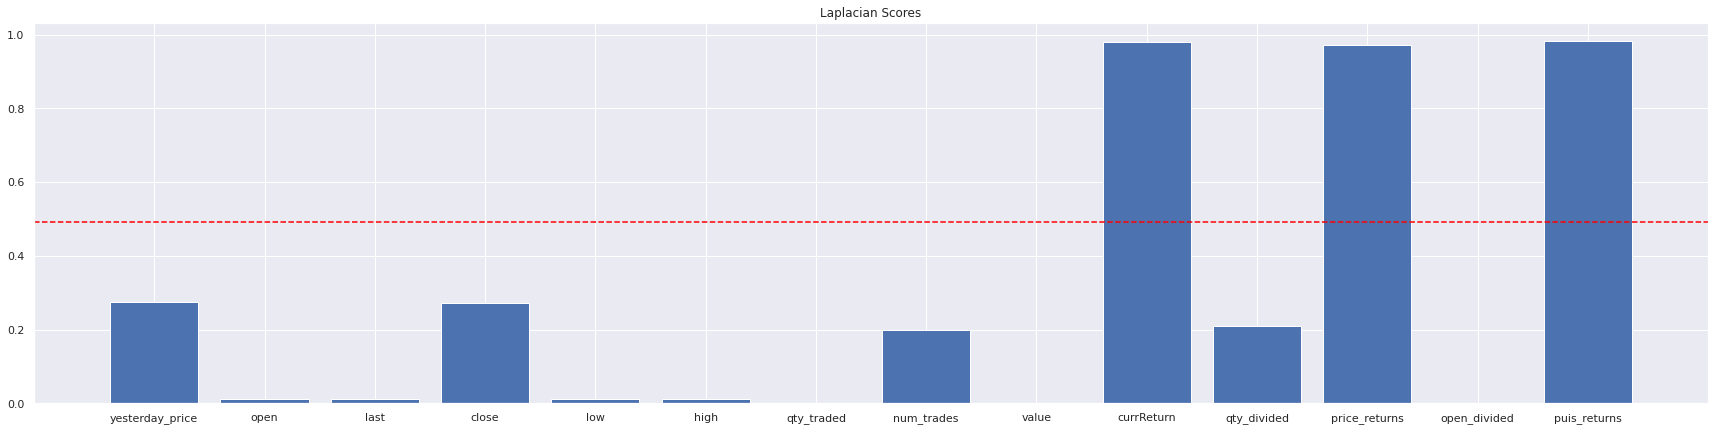

In [ ]:
# Select features based on the previous selected parameter 
var = var_list[np.argmin(rmse_list)]

start_time=time.time()
W_LS = laplacian_score(X, var=var, k =k)
end_time=time.time()
print('time to finish: ', end_time - start_time)

th = np.max(W_LS)/2

# Display the weights of features 
plt.figure(figsize=(30,7))
plt.title('Laplacian Scores')
plt.bar(features, W_LS)
plt.axhline(y=th, color= 'red',linestyle='--')
plt.show()

# Train test split 
X_LS = X[:,np.where(W_LS> th)[0]] 
X_train_LS = X_LS[:size1]
X_test_LS = X_LS[size1:]

In [ ]:
print('- Random Forest:')
mae, rmse, mape = RF_regression(X_train_LS, y_train, X_test_LS, y_test, data.index, size1)

- Random Forest:
Best Validation Score: 99.31669133513381
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}


Mean Absolute Error on test data: 68.483
Root Mean Squared Error on test data: 101.23
Mean Absolute Percentage Error on test data: 3.766


In [ ]:
print('- Gradient Boosting:')
GB_regression(X_train_LS, y_train, X_test_LS, y_test, data.index, size1)

- Gradient Boosting:
Best Validation Score: 99.22398960891496
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 10}


Mean Absolute Error on test data: 67.827
Root Mean Squared Error on test data: 98.919
Mean Absolute Percentage Error on test data: 4.318


In [ ]:
print('- Neural Network:')
NN_regression(X_train_LS, y_train, X_test_LS, y_test, data.index, size1)

- Neural Network:
Epoch 1/120
16/16 [==============================] - 3s 41ms/step - loss: 16593.4785 - root_mean_squared_error: 128.8157 - val_loss: 44799.3672 - val_root_mean_squared_error: 211.6586
Epoch 2/120
16/16 [==============================] - 0s 7ms/step - loss: 15990.5225 - root_mean_squared_error: 126.4536 - val_loss: 46404.9922 - val_root_mean_squared_error: 215.4182
Epoch 3/120
16/16 [==============================] - 0s 7ms/step - loss: 14696.4307 - root_mean_squared_error: 121.2288 - val_loss: 52741.1055 - val_root_mean_squared_error: 229.6543
Epoch 4/120
16/16 [==============================] - 0s 7ms/step - loss: 13584.7012 - root_mean_squared_error: 116.5534 - val_loss: 53469.9258 - val_root_mean_squared_error: 231.2357
Epoch 5/120
16/16 [==============================] - 0s 7ms/step - loss: 13901.1133 - root_mean_squared_error: 117.9030 - val_loss: 51530.0078 - val_root_mean_squared_error: 227.0022
Epoch 6/120
16/16 [==============================] - 0s 6ms/step -

Mean Absolute Error on test data: 64.792
Root Mean Squared Error on test data: 99.557
Mean Absolute Percentage Error on test data: 3.056


## Final Results

- **Mean Absolute Error:** 

<center>

||w/o Feature Selection| REFS | UDFS | Laplacian Score |
|---|---|---|---|---|
Random Forest | <center>$74.661$<center>| <center>$69.676$<center> |<center>$\bf{60.343}$<center>|<center>$\underline{68.483}$<center> |
Gradient Boosting | <center>$73.782$<center>|<center>$69.336$<center>|<center>$\bf{59.409}$<center>|<center>$\underline{67.827}$<center> |
Neural Network | <center>$82.606$<center>|<center>$\underline{62.066}$<center>|<center> $\bf{54.892}$<center>|<center>$64.792$<center> |



- **Root Mean Squared Error:**

<center> 

||w/o Feature Selection| REFS | UDFS | Laplacian Score |
|---|---|---|---|---|
Random Forest | <center>$101.685$<center> |  <center>$108.248$ <center>|  <center>$\bf{94.967}$<center>|<center>$\underline{101.23}$<center> |
Gradient Boosting |<center>$98.985$<center>| <center>$111.701$<center>|<center>$\bf{93.601}$<center>|<center>$\underline{98.919}$<center>| 
Neural Network | <center>$111.791$<center> |<center>$\underline{97.09}$<center>|<center>$\bf{95.486}$<center>|<center>$99.557$<center> |

- **Mean Absolute Percentage Error:** 

<center>

||w/o Feature Selection| REFS | UDFS | Laplacian Score |
|---|---|---|---|---|
Random Forest | <center>$5.312$<center>| <center>$3.993$<center> |<center>$\bf{3.398}$<center> |<center>$\underline{3.766}$<center> | 
Gradient Boosting |<center>$6.125$<center>|<center>$\underline{4.237}$<center>|<center>$\bf{3.223}$<center>|<center>$4.318$<center> |
Neural Network |  <center>$4.411$<center>|<center>$3.951$<center> | <center>$\bf{2.341}$<center> |<center>$\underline{3.056}$<center>|

- **Time to finish:** 

<center>

||Time to finish  (seconds)|  
|---|---|
REFS | <center>$\bf{0.0236}$<center>| 
UDFS | <center>$\underline{0.2914}$<center> |
Laplacian Score | <center>$0.6481$<center> | 